<a href="https://colab.research.google.com/github/crazycloud/dl-blog/blob/master/_notebooks/2020_09_20_Entity_Extraction_Transformers_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Entity Extraction (NER) - Training and Inference using Transformers - Part 1"
> Learn to train a NER model using Transformers Trainer Class, and to run Inference using Pipeline function

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [nlp, token classification]
- image: images/transformers-ner-part1.png
- hide: false

**In Part-1, we will discuss how to use the Pretrained language model, the Token Classification Head, and Tokenizer. You can skip the Part-1 if you want to go ahead and check the finetuning demo and model prediction.**

**In Part-2, we will learn to finetune the TokenClassification head of RoBerta model.**

## Token Classification Task
The token classification task identifies the entities of interest in the text. For NER task, we identify the Named entities like Person, Location, Organization and etc.

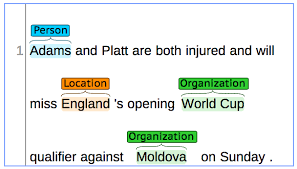

Fig 0. NER task

## Pretrained Language Model
A pretrained language model like BERT, ALBERT provides the [contextual embedding](http://ai.stanford.edu/blog/contextual/) for a token. The contextual embedding is the representation based on the sentence/context a token is used in. So it will understand difference between a River Bank and a Financial Banks. 

### What is a token?  
A token could be a whole word or a substring of a word. If a word is not part of the model vocabulary it would be broken down into subwords based on some algorithm.

There are 3 important parts of a pretrained language model 

Model - Neural Network model Architecture
Tokenizer - Preprocessor for converting the text into the input representation that the model can understand.  
Model Weights - The weights of the model are saved in a seperate file.

### How to use a pretrained model for a specific task?
For any task like NER or Classification, we add a Task head(another Neural Network layer on top of base model) to map word embedding into output labels. During the Training process we learn weights of the head to classify each token properly.


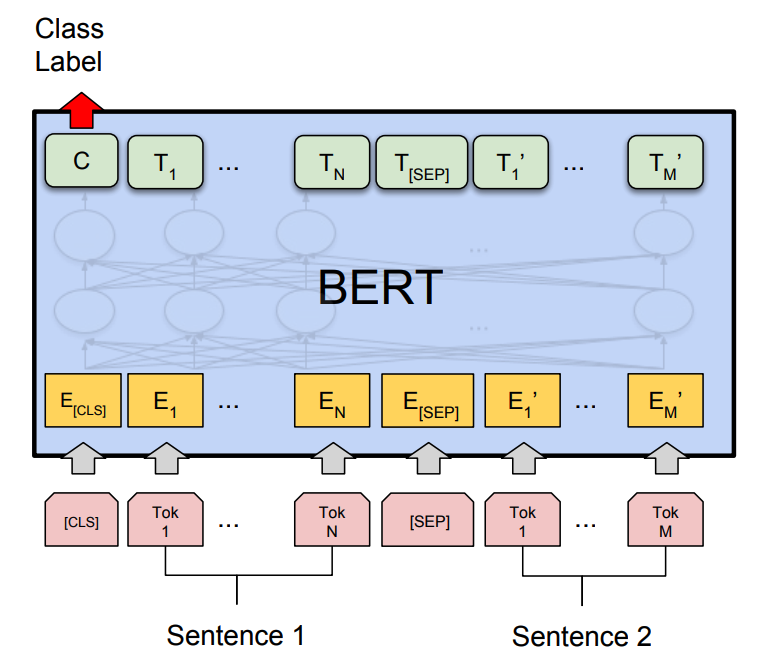

Fig 1. Pretrained Bert Model without any task specific head. Each sentence is converted into token embedding Tok1, Tok2 using a Tokenizer and the fed into the Model which outputs new representation for each token Tok1, Tok2 .. along with additional token [CLS] and [SEP]

## Installation

Install the latest package of transformers from the github or follow the installation instructions here https://huggingface.co/transformers/installation.html

In [ ]:
#install the latest transformers library 
!pip install git+https://github.com/huggingface/transformers.git

In [17]:
import transformers 
transformers.__version__

## 3.1.0

'3.1.0'

## Base Language Model

Roberta Pretrained embeddings, or any other Language Model embeddings, provides a vector representation for each token. A word could be broken down into multiple tokens by the tokenizer.

In [19]:
from transformers import AutoModel, AutoTokenizer
import torch

# Load the Ro pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModel.from_pretrained('roberta-base')

## Tokenizer
A tokenizer
* split the sentence into words and then further into subwords if the word is not part of the Tokenizer Vocabulary. 
* assign id to each token based on the vocabulary dictionary (word to integer mapping)

Since the pretrained models are not trained for any specific domains, they consider Top N high frequency tokens. It is not possible to add all the words to the model vocabulary because that would drastically increase the model Embedding layer weights and also, lot of new words are added to dictionary every now and then.

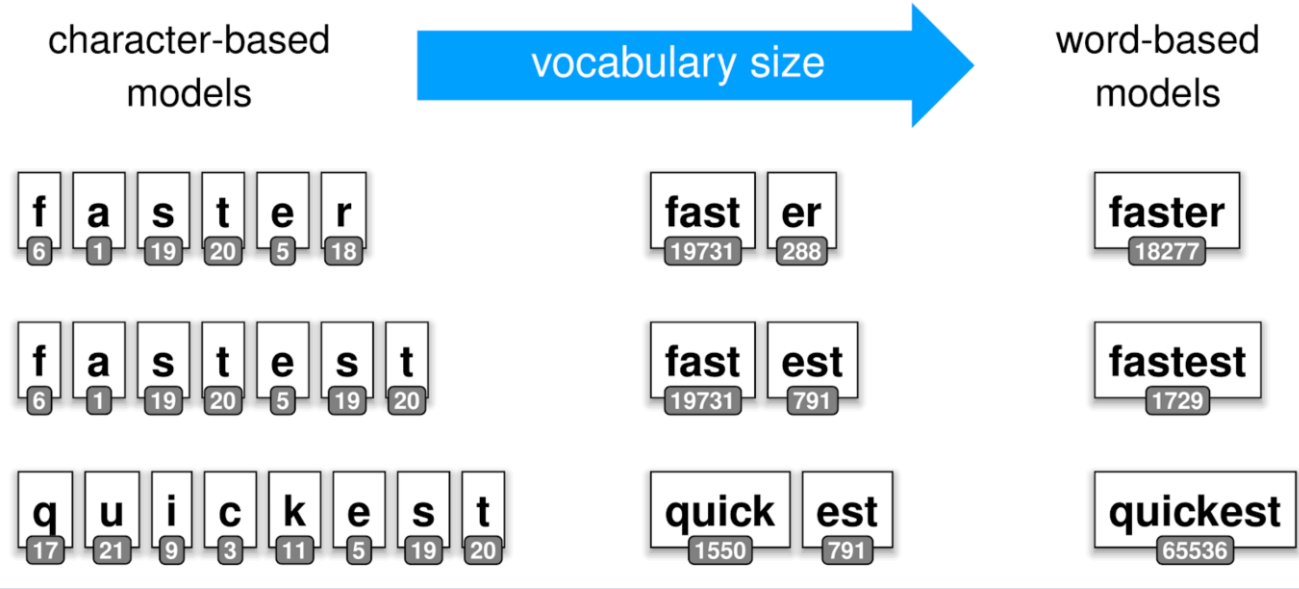

Fig 2. The above picture is taked from the [Huggingface Tokenizer example](https://colab.research.google.com/github/huggingface/transformers/blob/master/notebooks/01-training-tokenizers.ipynb). It clearly illustrates the character level, the token level and the word level tokenizer. 

The middle one is the Token level Tokenizer which is used frequently now a days.

In [18]:
#The Roberta tokenizer vocabulary size
tokenizer.vocab_size

50265

In [ ]:
#list all the vocabulary words in the tokenizer
tokenizer.get_vocab()

Any word not present in the vocabulary will be split into tokens.

In [25]:
#__call__ method Returns a dictionary containing the encoded sequence or sequence pair and additional informationReturns a dictionary containing the encoded sequence or sequence pair and additional information
#tokenize the sentence using __call__ method of the tokenizer
inputs = tokenizer("""Today, Sachin won't be playing in the cricket match between India and Pakistan.""", return_tensors='pt')
inputs

{'input_ids': tensor([[    0,  5625,     6, 19686,   179,   351,    75,    28,   816,    11,
             5,  5630,   914,   227,   666,     8,  1752,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Let's decode the token id's to see the token text

In [23]:
[tokenizer.decode(i) for i in inputs['input_ids'][0].tolist()]

['<s>',
 'Today',
 ',',
 ' Sach',
 'in',
 ' won',
 "'t",
 ' be',
 ' playing',
 ' in',
 ' the',
 ' cricket',
 ' match',
 ' between',
 ' India',
 ' and',
 ' Pakistan',
 '.',
 ' Sach',
 'in',
 ' wil',
 '</s>']

The word Sachin is split into ['Sach,'in'] tokens. This method of splitting a word into tokens helps in handling out of vocabulary words.

### Special Tokens 

Roberta uses special token `<s>` to mark sentence boundaries. While BERT has special tokens like `[CLS]  [SEP]` 

[CLS] provides the vector representation for the whole sentence and [SEP] token is useful when we have to encode two sentences.



### Tokenize a sentence 

There are a lot of [tokenizer functions](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.convert_tokens_to_ids) available in the transformers library. It can get really confusing as to which function to use and when.

`__call__` method is a wrapper around the `tokenizer.tokenize` method. It adds special tokens specific to the model and returns additional fields like `token_type_ids` and `attention_masks`

`tokenize` method splits the sentence into tokens without adding any special tokens.

`convert_tokens_to_ids` is called after converting a string into tokens, to convert the tokens into vocabulary token ids

In [29]:
tokens = tokenizer.tokenize("I don't like it here")
tokens

['I', 'Ġdon', "'t", 'Ġlike', 'Ġit', 'Ġhere']

In [30]:
tokenizer.convert_tokens_to_ids(tokens)

[100, 218, 75, 101, 24, 259]

In [31]:
tokenizer.build_inputs_with_special_tokens(tokens)

[0, 'I', 'Ġdon', "'t", 'Ġlike', 'Ġit', 'Ġhere', 2]

use the `__call__` method to get the token_ids with extra inputs required by the specific model.

In [ ]:
tokenizer("I don't like it here")

{'input_ids': [2, 31, 221, 22, 38, 101, 32, 235, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

Before trying to understand the **attention_mask** and **token_type_ids** return values. Let us first look at the inputs required by a transformers model.

# Model Inputs

The base RoBERTa Model provides the raw hidden-states without any specific head on top.

The forward method of the Model has following input parameters

 > def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

**input_ids** - The input ids are often the only required parameters to be passed to the model as input. These are numerical representation of the tokens the one which we got in the previous step using tokenizer call method.

**attention_mask** - A binary value representing whether to attend to the corresponding input_id token or not. It is useful when we have different length sentences in a batch and we need to pad all sentences to the same length. We ignore the padding index input_id using attention mask.

**token_type_id** - Useful when encoding multiple sentences. 


The tokenizers `__call__` method handles everything to prepare the input for the model. It does more than just encoding the sentence into numeric representation.

## Model Inference / Output

Run the model for the input sentence and get the embedding for each token

In [32]:
output = model(**inputs)

In [33]:
output[0].shape
#(batch_size, #tokens, embedding_dim)

torch.Size([1, 19, 768])

We provided a single sentence as input to the model, hence the batch_size of 1. 

The tokenizer converted the sentence into 19 tokens, including the special tokens then the model converted each token into a vector representation of 768 dimension, hence [19,768]

In [36]:
output[1].shape
#pooled output - the vector representation of a whole sentence

torch.Size([1, 768])

In [38]:
output = model(input_ids= inputs['input_ids'], attention_mask=inputs['attention_mask'] , return_dict=True)

 > if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

>return BaseModelOutputWithPooling(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

To return hiddden states and attentions, we have to set output_attentions and output_hidden_states in the model call

In [43]:
output = model(input_ids= inputs['input_ids'], attention_mask=inputs['attention_mask'] , return_dict=True, output_hidden_states=True, output_attentions= True)

In [44]:
len(output.attentions)

12

In [45]:
output.attentions[0].shape

torch.Size([1, 12, 19, 19])

## Token Classification(TC) Head for Entity Extraction

What we have learned so far - 

- How to tokenize a sentence using model specific tokenizer
- How to get contextual embeddings using the Pretrained Model

The Token classification task assigns a label to each token in the sentence. 

For example in the sentence 

"The battery of the speaker is very poor."  
TC head will map each token embedding to a label like 

- `The` O  
- `battery` Aspect
- `of` O 
- `the` O  
- `speaker` O 
- `is` O 
- `very` Sentiment
- `poor` Sentiment. 

Here, we wanted to extract the Aspect and the Sentiment in the text. O is Others.





###  RoBerta Token Classification Head
Since we have the embedding vector for each token, if we add a linear head on top of the embedding to map each embedding to one of the labels, we will get a label for each token.

hidden_size of Roberta is 786, and depending on the num_labels(the entities of interest) it will do the token classification

From [RobertaTokenClassification](https://github.com/huggingface/transformers/blob/4f6e52574248636352a746cfe6cc0b13cf3eb7f9/src/transformers/modeling_roberta.py#L602) code

>self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
self.dropout = nn.Dropout(config.hidden_dropout_prob)
sequence_output = self.dropout(sequence_output)
logits = self.classifier(sequence_output)

(N, T, 786) -> (N, T, num_labels)

N - batch_size
T - Number of tokens 


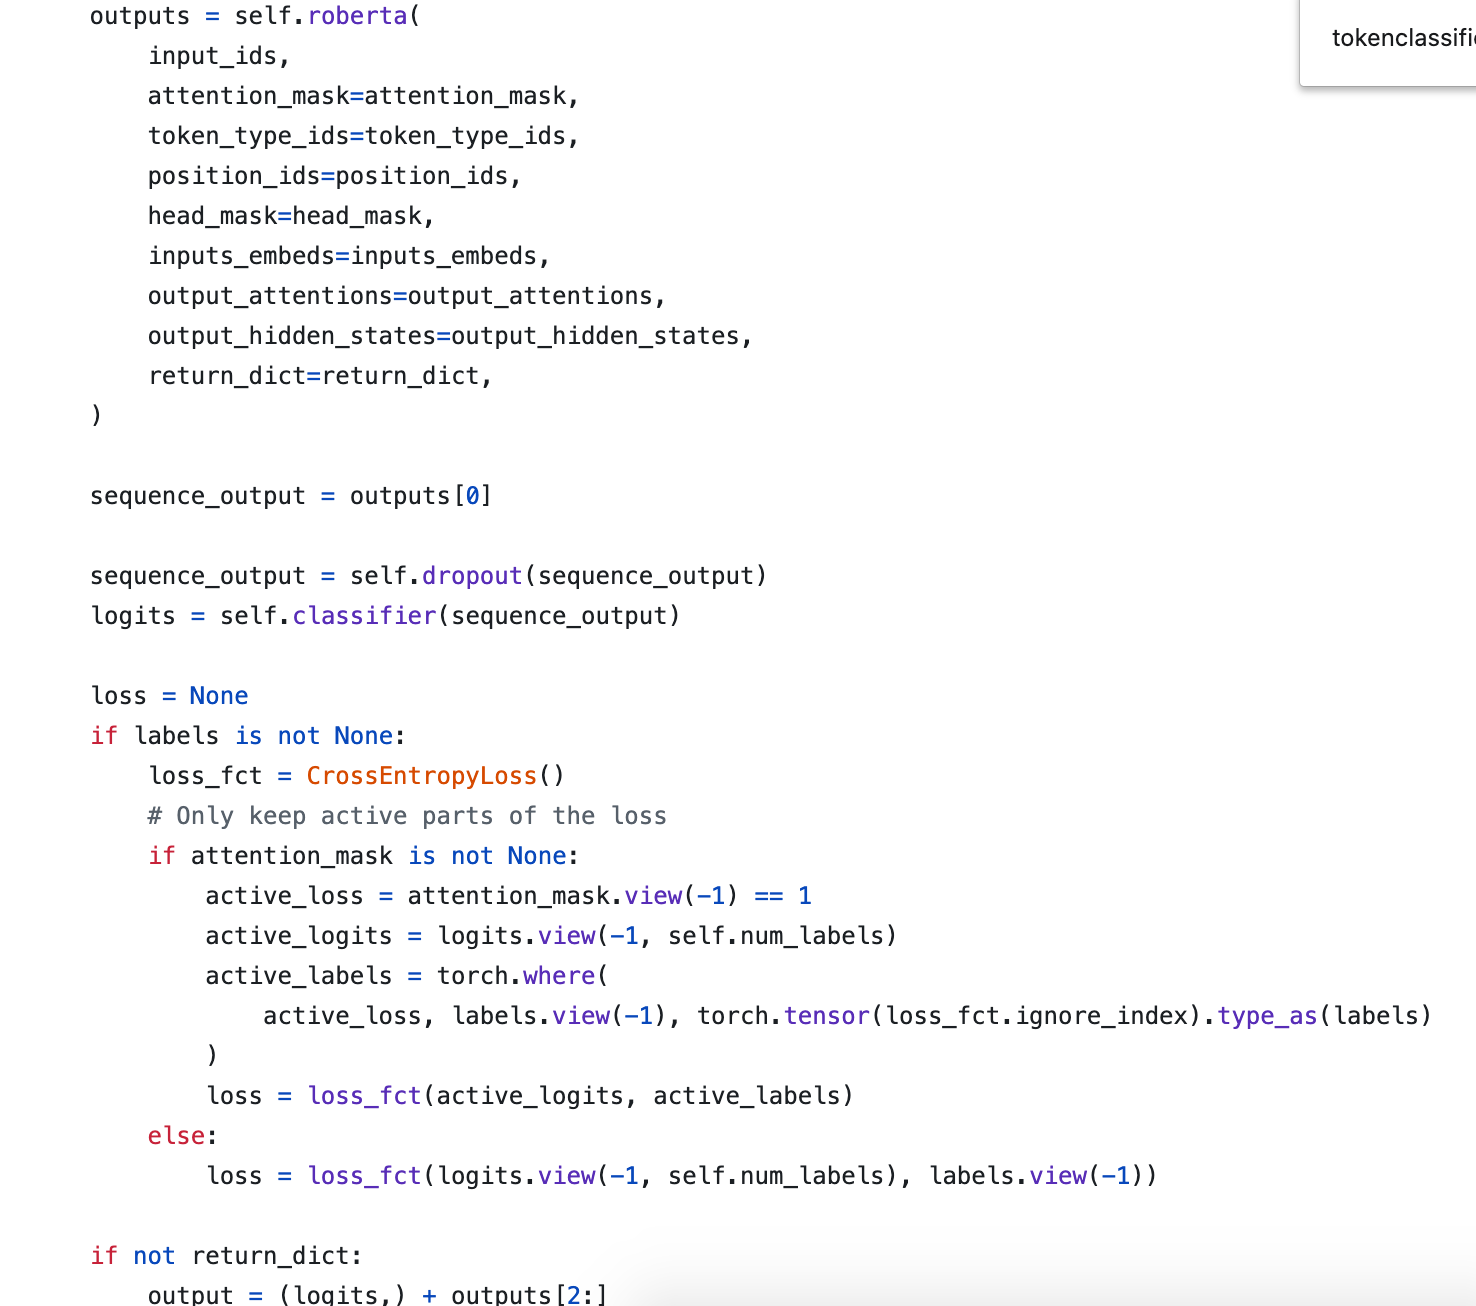

### Token Classification Output

During Training, we will provide labels along with the input_ids to the model. The model calculates the CrossEntropy Loss of the predicted labels and the ground truth and the weights are updated with the gradient. 

Task Head will return the loss if labels are provided as part of the model input

>output = (logits,) + outputs[2:]
return ((loss,) + output) if loss is not None else output

loss is the cross entropy loss between the labels and the logits 

>loss_fct = CrossEntropyLoss()
loss_fct(logits.view(-1, self.num_labels), labels.view(-1))



In [51]:
from transformers import AutoModelForTokenClassification,RobertaForTokenClassification

Let us run Token Classification model Prediction without any finetuning to see the output of the model

In [49]:
 from transformers import AutoConfig 
 config = AutoConfig.from_pretrained(
        'roberta-base',
        num_labels=3,
        id2label={0:'ASPECT',1:'OTHERS',2:'EXTRA'},
        label2id={label: i for i, label in enumerate(['ASPECT','OTHERS','EXTRA'])}
    )

In [50]:
config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "ASPECT",
    "1": "OTHERS",
    "2": "EXTRA"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "ASPECT": 0,
    "EXTRA": 2,
    "OTHERS": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

In [ ]:
model = RobertaForTokenClassification.from_pretrained('albert-base-v2', config = config)

In [57]:
output = model(**inputs)
output

(tensor([[[ 8.0052e-01, -7.5425e-02,  4.5114e-01],
          [ 8.4571e-01, -2.9972e-01,  1.7145e-01],
          [ 9.3446e-01, -7.4490e-01,  1.6924e-01],
          [ 2.6570e-01,  1.0174e-01,  5.2277e-01],
          [ 4.5587e-01, -1.6770e-01,  8.7134e-01],
          [ 1.2516e+00, -6.7618e-01,  7.1735e-01],
          [ 7.4633e-01,  4.1005e-01,  4.7558e-01],
          [ 5.2609e-01, -9.0839e-02,  5.9321e-01],
          [ 8.0308e-01, -2.6667e-01,  1.1635e+00],
          [ 7.8067e-01,  9.4608e-02,  4.2717e-02],
          [ 6.4042e-01, -1.1400e-01,  1.8376e-01],
          [ 2.9740e-01, -3.3065e-01,  7.9212e-01],
          [ 8.3010e-01, -6.5126e-01,  5.6326e-01],
          [ 4.0874e-01, -1.6919e-01,  1.2946e+00],
          [ 9.3214e-01,  2.3070e-01,  3.4809e-01],
          [ 9.2671e-01, -4.8473e-01,  3.4551e-01],
          [ 5.1119e-01, -2.8516e-01,  2.6419e-01],
          [ 6.8518e-01, -6.7281e-01,  6.1023e-01],
          [ 6.1454e-01, -1.0960e-03,  2.6023e-01]]], grad_fn=<AddBackward0>),)

In [58]:
output[0].shape

torch.Size([1, 19, 3])

This outputs a 3-label probabilities for each token.

During training, we will provide the labels also as input to the model which will calculate the CorssEntropy loss. 

In [59]:
labels = torch.randint(0,3,(19,))

In [64]:
outputs = model(input_ids = inputs['input_ids'],attention_mask= inputs['attention_mask'],  labels = labels)
loss = outputs[0]

In the next Part, we will discuss about finetuning the model for Entity Extraction Task